In [85]:
# ML Assignment2: 
# https://github.com/visualizedata/ml/blob/master/final_assignment_2/images_starter.ipynb
# Code from Aaron Hill

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
from skimage import io, color, transform, feature, data
from skimage.feature import hog, daisy
from my_measures import BinaryClassificationPerformance  
from sklearn.model_selection import train_test_split
%matplotlib inline

In [86]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.03
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

In [87]:
# file paths
ci_path = '/Users/yichanwang/Dropbox/2020Fall_Parsons/MachineLearning/Assignment2/data/cropped_images_18/'
l_file = '/Users/yichanwang/Dropbox/2020Fall_Parsons/MachineLearning/Assignment2/data/plane_labels_2018.csv'

In [88]:
# in downscaling the image, what do you want the new dimensions to be?
# the original dimensions of cropped images: (60, 140), which if 8,400 pixels
dims = (15, 35) # 25% of the original size, 525 pixels

downscaled image shape: 
(60, 140, 3)
image representation (first row of pixels): 
[[0.05018261 0.58957462 0.58957462]
 [0.06057626 0.52118425 0.52118425]
 [0.11230471 0.11230471 0.11230471]
 [0.08849255 0.08849255 0.08849255]
 [0.09241412 0.09241412 0.09241412]
 [0.10025725 0.10025725 0.10025725]
 [0.11202196 0.11202196 0.11202196]
 [0.12378667 0.12378667 0.12378667]
 [0.13555137 0.13555137 0.13555137]
 [0.14563451 0.14563451 0.14563451]
 [0.14955608 0.14955608 0.14955608]
 [0.14955608 0.14955608 0.14955608]
 [0.15739922 0.15739922 0.15739922]
 [0.16467686 0.16467686 0.16467686]
 [0.16859843 0.16859843 0.16859843]
 [0.16467686 0.16467686 0.16467686]
 [0.16075529 0.16075529 0.16075529]
 [0.1601898  0.1601898  0.1601898 ]
 [0.15626824 0.15626824 0.15626824]
 [0.06465428 0.52526226 0.52526226]
 [0.02543055 0.81327083 0.81327083]
 [0.06465428 0.52526226 0.52526226]
 [0.1198651  0.1198651  0.1198651 ]
 [0.12014784 0.12014784 0.12014784]
 [0.12406941 0.12406941 0.12406941]
 [0.12406941 0.12

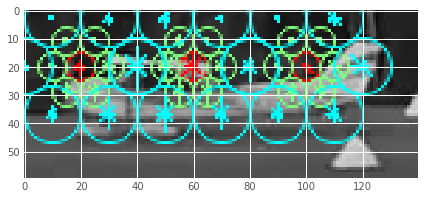

In [89]:
# # Canny Edge Detection
# def image_manipulation(imname, imgs_path, imview=False):
#     warnings.filterwarnings('ignore')
#     imname = imgs_path + imname + '.png'
#     img_raw = io.imread(imname, as_gray=True)
    
#     downscaled = transform.resize(img_raw, (dims[0], dims[1])) # downscale image
#     final_image = feature.canny(downscaled) # edge filter image with Canny algorithm
    
#     if imview==True:
#         io.imshow(final_image)
#     warnings.filterwarnings('always')
#     return final_image

# Hog
# def image_manipulation(imname, imgs_path, imview=False):
#     warnings.filterwarnings('ignore')
#     imname = imgs_path + imname + '.png'
#     img_raw = io.imread(imname)

#     fd, hog_image = hog(img_raw, orientations=4, pixels_per_cell=(12, 12),
#                     cells_per_block=(4, 4), visualize=True, multichannel=True)
#     final_image = np.array([hog_image])

#     if imview==True:
#         io.imshow(hog_image)
#     warnings.filterwarnings('always')
#     return final_image

# Daisy
def image_manipulation(imname, imgs_path, imview=False):
    warnings.filterwarnings('ignore')
    imname = imgs_path + imname + '.png'
    img_raw = io.imread(imname, as_gray=True)
    
    gray = color.rgb2gray(img_raw) # remove color
    descs, descs_img = daisy(gray, step=40, radius=20, rings=2, histograms=6,
                         orientations=8, visualize=True)
    final_image = descs_img
    
    if imview==True:
        io.imshow(final_image)
    warnings.filterwarnings('always')
    return final_image


# test the function, look at input/output
test_image = image_manipulation('2017-08-25T23+24+13_390Z', ci_path, True)
print('downscaled image shape: ')
print(test_image.shape)
print('image representation (first row of pixels): ')
print(test_image[0])
print('\n')
print('example of transformation: ')

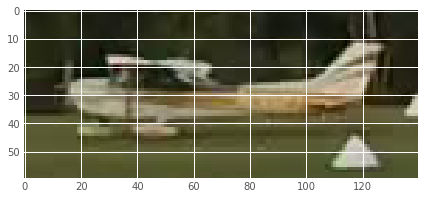

In [73]:
this_imname = ci_path + '2017-08-25T23+24+13_390Z.png'
io.imshow(io.imread(this_imname))

In [74]:
# function that takes raw images and completes all preprocessing required before model fits
def process_raw_data(labels_fn, images_fp, my_random_seed, imview=False, test=False):
    plane_data = pd.read_csv(labels_fn) # read in photograph labels
    print("First few lines of image labels: ")
    print(plane_data.head())
    print("Size of image label dataFrame: ")
    print(plane_data.shape)
        
    # construct lists for features, labels, and a crosswalk reference to image names
    features_list = []
    if (not test):
        y_list = []
    imnames_list = []

    for index, row in plane_data.iterrows():
        features_list.append(image_manipulation(row['img_name'], images_fp))
        if (not test):
            y_list.append(row['plane'])
        imnames_list.append(row['img_name'])
    
    # convert the lists to ndarrays
    features = np.asarray(features_list)
    if (not test):
        Y = np.asarray(y_list)
    imgs = np.asarray(imnames_list)
    print('Shape of original feature representation: ')
    print(features.shape)

    # flatten the images ndarray to one row per image
    features_flat = features.reshape((features.shape[0], -1))

    print('Shape of flat feature representation: ')
    print(features_flat.shape)

    if (not test):
        print('Shape of Y: ')
        print(Y.shape)

        print('Number of images with planes: ')
        print(Y.sum())
    
        # create train and test sets
        data_train, data_test, y_train, y_test, imgs_train, imgs_test = train_test_split(features_flat, 
            Y, imgs, test_size = 0.25, random_state = my_random_seed)

        print('Shape of training set: ')
        print(y_train.shape)
        print('Number of training images that contain an airplane: ')
        print(y_train.sum())

        print('Shape of test set: ')
        print(y_test.shape)
        print('Number of test images that contain an airplane: ')
        print(y_test.sum())
    
    if (test):
        X_submission_test = features_flat
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(X_submission_test, plane_data)
    else: 
        print("Shape of data_train and data_test:")
        print(data_train.shape)
        print(data_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of imgs_train and imgs_test:")
        print(imgs_train.shape)
        print(imgs_test.shape)
        print('SUCCESS!')
        return(data_train, data_test, y_train, y_test, imgs_train, imgs_test)

In [75]:
data_train, data_test, y_train, y_test, imgs_train, imgs_test = process_raw_data(l_file, ci_path, 
    my_random_seed=27, imview=False, test=False)

First few lines of image labels: 
                   img_name  plane
0  2016-08-02T13+50+24_430Z  False
1  2016-08-02T14+12+37_390Z  False
2  2016-08-02T22+20+26_600Z  False
3  2016-08-03T12+04+30_670Z  False
4  2016-08-03T12+32+21_790Z  False
Size of image label dataFrame: 
(6758, 2)
Shape of original feature representation: 
(6758, 60, 140, 3)
Shape of flat feature representation: 
(6758, 25200)
Shape of Y: 
(6758,)
Number of images with planes: 
101
Shape of training set: 
(5068,)
Number of training images that contain an airplane: 
75
Shape of test set: 
(1690,)
Number of test images that contain an airplane: 
26
Shape of data_train and data_test:
(5068, 25200)
(1690, 25200)
Shape of y_train and y_test:
(5068,)
(1690,)
Shape of imgs_train and imgs_test:
(5068,)
(1690,)
SUCCESS!


In [76]:
# MODEL: Perceptron
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(data_train, y_train)

prc_performance = BinaryClassificationPerformance(prc.predict(data_train), y_train, 'prc')
prc_performance.compute_measures()
prc_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(prc_performance.performance_measures)

prc_performance_test = BinaryClassificationPerformance(prc.predict(data_test), y_test, 'prc')
prc_performance_test.compute_measures()
prc_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(prc_performance_test.performance_measures)

prc_performance_test.img_indices()
prc_img_indices_to_view = prc_performance_test.image_indices

TRAINING SET: 
{'Pos': 75, 'Neg': 4993, 'TP': 75, 'TN': 4993, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc', 'set': 'train'}
TEST SET: 
{'Pos': 26, 'Neg': 1664, 'TP': 21, 'TN': 1663, 'FP': 1, 'FN': 5, 'Accuracy': 0.9964497041420118, 'Precision': 0.9545454545454546, 'Recall': 0.8076923076923077, 'desc': 'prc', 'set': 'test'}


In [77]:
def performance_examples(typ, measures):
    iiv = ''
    if typ == 'FP':
        iiv = typ + '_indices'
    elif typ == 'TP':
        iiv = typ + '_indices'
    elif typ == 'FN':
        iiv = typ + '_indices'
    else:
        raise ValueError('input must be "TP", "FP", or "FN"')
    for img in measures[iiv]:
        warnings.filterwarnings('ignore')    
        plt.figure()
        lookat = ci_path + imgs_test[img] + '.png' # location of original image
        io.imshow(lookat) # show original image
        plt.figure()
        io.imshow(data_test[img].reshape(dims[0], dims[1])) # show manipulation for feature representation
        warnings.filterwarnings('always')

In [49]:
# performance_examples('TP', prc_img_indices_to_view)
# performance_examples('FP', prc_img_indices_to_view)

In [78]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(max_iter=1000)
print(nn)
nn.fit(data_train, y_train)

nn_performance = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance.compute_measures()
nn_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance.performance_measures)

nn_performance_test = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test.compute_measures()
nn_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test.performance_measures)

nn_performance_test.img_indices()
nn_img_indices_to_view = nn_performance_test.image_indices

MLPClassifier(max_iter=1000)
TRAINING SET: 
{'Pos': 75, 'Neg': 4993, 'TP': 75, 'TN': 4993, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 26, 'Neg': 1664, 'TP': 22, 'TN': 1664, 'FP': 0, 'FN': 4, 'Accuracy': 0.9976331360946745, 'Precision': 1.0, 'Recall': 0.8461538461538461, 'desc': 'nn_test', 'set': 'test'}


In [51]:
# performance_examples('TP', nn_img_indices_to_view)
# performance_examples('FP', nn_img_indices_to_view)

In [79]:
# list of fits to compare: 
final_fits = []
final_fits.append(prc_performance.performance_measures)
final_fits.append(prc_performance_test.performance_measures)
final_fits.append(nn_performance.performance_measures)
final_fits.append(nn_performance_test.performance_measures)

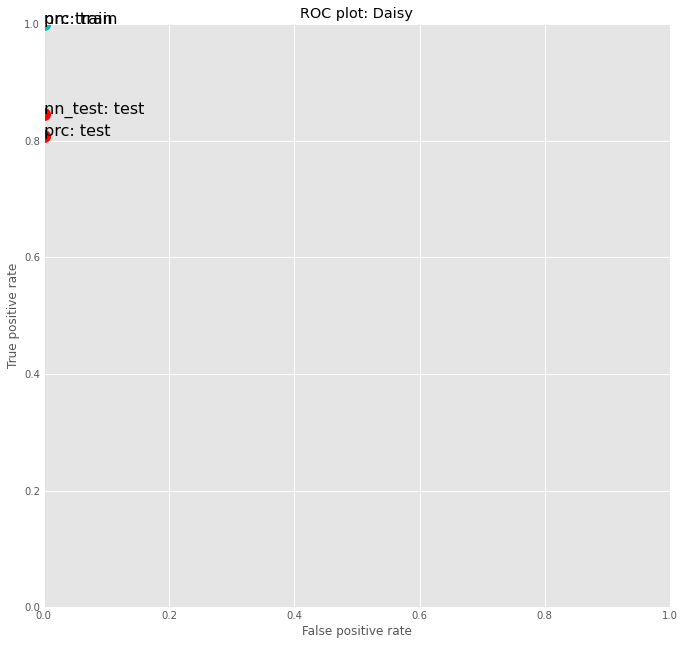

In [80]:
plt.style.use('fivethirtyeight')
plt.style.use('ggplot')

plt.figure(figsize=(10,10))

for fit in final_fits:
    if fit['set'] == 'train':
        color = 'co'
    else:
        color = 'ro'
    plt.plot(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], color, markersize=12)
    plt.text(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], fit['desc'] + ': ' + fit['set'], fontsize=16)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: Daisy')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()